# Markov chain Monte Carlo sampling

## From independent to dependent sampling

In the algorithms we have explored so far (rejection sampling, importance sampling), we draw independent samples from a proposal distribution and compare them to a target distribution.
However, we have seen that this quickly becomes inefficient, particularly in high dimensions.

**Markov chain Monte Carlo** methods address this problem by exploring the target distribution locally instead of globally. 
The idea to to start from an initial point and move through parameter space step by step, proposing new points that are close to the current one.
If we are already in a neighborhood with "good" points, this increases our chances of finding new points that we can accept.
Every proposed point only directly depends on the previous state – this property defines a *Markov chain*, giving the method its name.

At each step, the algorithm decides wether to accept or reject the new point by comparing the target density at the current and the proposed point.

- If the proposed point is more likely, it is accepted.
- If it is less likely, it may still be accepted with some probability.

We need to occasionally accept "worse" points to ensure that we explore the entire target distribution instead of always moving towards the mode of the distribution (or local maxima).
Overall, we must strike a balance between moving far enough to explore new regions and staying close enough to maintain a reasonable acceptance rate.

### Detailed balance

To ensure that the Markov chain eventually produces samples from the target distribution, the transition from the current state, $x$, to the new state $x^\prime$ must satisfy a specific condition known as *detailed balance*:

$$p(x) T(x^\prime \mid x) = p(x^\prime) T(x \mid x^\prime)\,,$$

where $p(x)$ and $p(x^\prime)$ are the target density at the current and new state, respectively.
$T(x^\prime \mid x)$ is the probability of moving from $x^\prime$ to $x$.
That is, the probability of being in state $x$ and transitioning from $x$ to $x^\prime$ must equal the probability of being in state $x^\prime$ and transitioning from $x^\prime$ to $x$.

When this condition holds, the Markov chain has $p(x)$ as its stationary distribution, meaning that after sufficient iterations, samples drawn from the chain follow the desired target distribution.

## The Metropolis-Hastings algorithm

The Metropolis-Hastings algorithm is a simple and general algorithm based on the principles of Markov chain Monte Carlo sampling.
Similar to rejection and importance sampling, it uses the idea of a *proposal distribution*.
However, in this case, the proposal distribution is used to define the transition probabilities.
The PDF of the proposal distribution, $q(x^\prime \mid x)$, gives the probability density of point $x^\prime$, given the current point $x$.
In practice, the point $x$ is often used as the location parameter of the proposal distribution so that it is centered around the current point.



### Algorithm steps

1. *Propose a new point* $x^\prime$ based on the current point $x_t$ and a proposal distribution $q(x^\prime \mid x_t)$.
2. *Compute the acceptance probability*:

   $$A(x^\prime, x_t) = \min\left(1, \frac{p(x^\prime)}{p(x_t)}\frac{q(x_t \mid x^\prime)}{q(x^\prime \mid x_t}\right)$$

3. Generate a *sample from a uniform distribution*
4. *Accept or reject* the proposed point.

   - If $u \leq A(x^\prime, x_t)$: accept the proposed state: $x_{t+1} = x^\prime$.
   - Otherwise, reject it: $x_{t+1} = x_t$.

### Simplification for a symmetric proposal distribution
  
When the proposal distribution is symmetric (for example, a normal distribution centered at the current point), the acceptance probability simplifies to:

$$A(x^\prime, x_t) = \min\left(1, \frac{p(x^\prime)}{p(x_t)}\right)$$

If the proposed point $x^\prime$ is "better" than the current one (i.e., it has a higher target PDF), the acceptance probability $A(x^\prime, x_t)$ equals one.
Thus, a "better" point will always be accepted.
If the target density at the proposed point $p(x^\prime)$ is much smaller than $p(x_t)$, the ratio $\frac{p(x^\prime)}{p(x_t)}$ will be close to zero.
As a result, $u$ will in most cases be larger than the acceptance probability, leading to rejection of the point.
However, with a small probability, even a "worse" point is accepted.

This version of the algorithm with a symmetric proposal distribution is known as the *Metropolis algorithm*.



### Animation

The animation below (created by {cite:t}`fengMarkovchainMonteCarlo2025`) illustrates the behavior of a random-walk Metropolis-Hastings sampler for a two-dimensional parameter space.
The blue shaded background and contours show the target distribution.
Dots represent samples.
The two circles around the current sample represent the proposal distribution.
The arrows show the next proposed point. If the arrow turns green, it means that the proposed point is accepted.
If it turns red, the proposed point is rejected.

In the control menu, you can change the standard deviation of the proposal distribution (Algorithm Options → Proposal $\sigma$).
Increase and decrease the standard deviation to explore how this affects sampling.

```{admonition} Animation not working?
:class: note
In case that the animation is not showing, try reloading the page. Alternatively, you can [view the animation here](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=banana).
```


````{div} full-width

<iframe src="https://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=banana"
        title="MCMC animation"
        width="100%"
        height="700"></iframe>

````

In [1]:
%config InlineBackend.figure_format = 'svg'

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("../styles/tu_delft.mplstyle")

In [3]:
import scipy.stats as stats
from metropolishastings import sample_metropolis_hastings
import numpy as np
import pandas as pd
from IPython.display import IFrame
from myst_nb import glue

In [4]:
def draw_proposal_sample(x, proposal_cov):
    # Draws a sample from a Normal proposal distribution centered at `x` with standard deviation `proposal_std`
    return stats.multivariate_normal(mean=x, cov=proposal_cov).rvs()


def compute_proposal_logpdf(x, y, proposal_cov):
    # Computes the PDF value of proposing `y` given `x` in the proposal distribution
    return stats.multivariate_normal(mean=x, cov=proposal_cov).logpdf(y)

# Define the target distribution
def evaluate_target_pdf(x):
    """Target distribution with two peaks."""
    return 0.3 * np.exp(-0.2 * (x - 2) ** 2) + 0.7 * np.exp(-0.2 * (x + 2) ** 2)

In [5]:
# Parameters for the algorithm
num_samples = 1000
proposal_cov = 100
start_value = 40

# Run the Metropolis-Hastings algorithm
samples = sample_metropolis_hastings(
    start_value,
    compute_target_logpdf=lambda x: np.log(evaluate_target_pdf(x)),
    compute_proposal_logpdf=compute_proposal_logpdf,
    draw_proposal_sample=draw_proposal_sample,
    num_samples=num_samples,
    proposal_cov=proposal_cov,
)




## Practical considerations

### Burn-in

The starting point of an MCMC simulation can be far from the region with most probability mass.
It then first needs to "travel" in parameter space before the Markov chain can reach a stationary distribution.
To speed up convergence, it is common to remove this initial "burn-in" period and only use the remaining samples.

The trace plot in {numref}`fig-mcmc-burnin` shows this behavior: During the first iterations, the sampler moves from the starting point closer to the mode of the distribution. Once it reached the region of higher density, the chain starts to fluctuate around parameter values with high density.


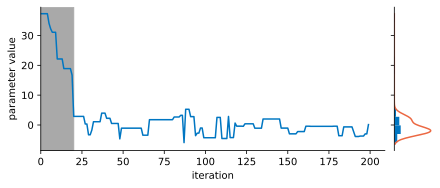

In [6]:
import seaborn as sns
fig = plt.figure(figsize=(6, 2.5), layout="constrained")
ax_dict = fig.subplot_mosaic(
    [
        ["trace", "true_marginal"],
    ],
    sharey=True,
    sharex=False,
    width_ratios=(0.9, 0.1),
    gridspec_kw={"hspace": 0.02}
)

ax_dict["trace"].axvspan(0, 20, color="darkgrey")
ax_dict["trace"].plot(samples[:200])
ax_dict["trace"].set_xlim(left=0)
ax_dict["trace"].set_xlabel("iteration")
ax_dict["trace"].set_ylabel("parameter value")
x_vals = np.linspace(np.min(samples), np.max(samples), 200)
target_vals = evaluate_target_pdf(x_vals)
ax_dict["true_marginal"].hist(samples[:200], bins=15, orientation="horizontal", density=True, )
ax_dict["true_marginal"].plot(target_vals, x_vals, color="C1")
ax_dict["true_marginal"].set_xticks([])
sns.despine(ax=ax_dict["true_marginal"], bottom=True)
sns.despine(ax=ax_dict["trace"])
glue("mcmc_burnin_plot", fig, display=False)

```{glue:figure} mcmc_burnin_plot
:width: 100%
:name: "fig-mcmc-burnin"

Trace plot showing the burn-in period of an MCMC simulation (shaded in grey). The plot on the right shows a histogram of the samples and the true target distribution for comparison.
```

### Assessing convergence

Even though a burn-in period may be clearly visible in trace plots, how do we know if the following samples sufficiently converged to the target density?
Unfortunately, there is no universally reliable test but a common approach is to run several independent chains from different starting points and compare their behavior.

Convergence can be assessed visually, for example using trace plots or comparing the marginal densities from the different chains.
For a more quantitative assessment, the potential scale reduction factor $\hat{R}$ (also known as the Gelman-Rubin statistics) is widely used.
It compares the variance between chains to the variance within chains – if the chains converged to the same distribution, the variances should be the same.
Therefore, values of $\hat{R}$ considerably greater than 1 suggest that the chains have not yet converged.
The statistic was first proposed by {cite:t}`gelmanInferenceIterativeSimulation1992`, with improved versions described by {cite:t}`vehtariRanknormalizationFoldingLocalization2021`.


### Autocorrelation

The local search approach of MCMC comes at the cost of generating dependent instead of independent samples.
Consecutive samples generated by the Metropolis-Hastings algorithm tend to be similar to each other, that is, they are correlated ({numref}`fig-mcmc-autocorrelation`).
This reduces the *effective sample size*, that is the equivalent number of independent samples with the same information content.

A practical trick to reduce autocorrelation of the samples is to *thin* the chain by only keeping every $n$th sample.
Alternatively, more sophisticated sampling algorithms that produce less correlated (or even anti-correlated) samples, such as [Hamiltonian Monte Carlo](sec-hmc), can be used.



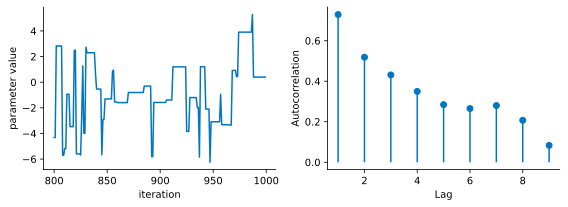

In [7]:
slice = range(800, 1000)

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(slice, samples[slice])
axs[0].set_xlabel("iteration")
axs[0].set_ylabel("parameter value");


def autocorrelation(x, lag):
    return np.corrcoef(x[:-lag], x[lag:])[0, 1]

# Calculate autocorrelations for each lag
lags = range(1, 10)
autocorrs = [autocorrelation(samples[slice], lag) for lag in lags]

# Plot
axs[1].stem(lags, autocorrs, basefmt=" ")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
sns.despine(fig)
glue("mcmc_autocorrelation_plot", plt.gcf(), display=False)

```{glue:figure} mcmc_autocorrelation_plot
:width: 100%
:name: "fig-mcmc-autocorrelation"

Trace plot (left) and autocorrelation plot (right) of an MCMC chain. The "plateaus" visible in the left plot show that consecutive samples are often similar.
This is also reflected in the positive autocorrelation (right plot) for lags up to about 5 iterations.
```

### Tuning the proposal distribution

The performance of the Metropolis-Hastings algorithm strongly depends on the proposal distribution:

- If the proposal variance (and thus, the step size) is too small, the chain moves very slowly and explores the distribution very locally. Almost all samples get accepted, but convergence is very slow ({numref}`fig-mcmc-acceptance-rate`).
- If the proposal variance is too large, most proposals are rejected because they "jump" outside the region with high probability density. The chain stays in place, only occasionally jumping randomly, wasting many samples.
- Ideally, the proposal distribution should balance exploration and acceptance. For multivariate problems, a target acceptance rate of about 23% has been found theoretically optimal.

The proposal distribution can also be updated during sampling, for example, tuning the proposal variance.
When parameters are correlated in the target distribution, it can also be beneficial to choose a multivariate proposal distribution (e.g., multivariate Gaussian) and adapt the covariance matrix based on previous samples.
This approach is known as *adaptive Metropolis*.



In [8]:
# Parameters for the algorithm
num_samples = 1000
proposal_cov = 0.05
start_value = 0

# Run the Metropolis-Hastings algorithm
samples_small_cov = sample_metropolis_hastings(
    start_value,
    compute_target_logpdf=lambda x: np.log(evaluate_target_pdf(x)),
    compute_proposal_logpdf=compute_proposal_logpdf,
    draw_proposal_sample=draw_proposal_sample,
    num_samples=num_samples,
    proposal_cov=proposal_cov,
)

# Parameters for the algorithm
num_samples = 1000
proposal_cov = 2000
start_value = 0

# Run the Metropolis-Hastings algorithm
samples_large_cov = sample_metropolis_hastings(
    start_value,
    compute_target_logpdf=lambda x: np.log(evaluate_target_pdf(x)),
    compute_proposal_logpdf=compute_proposal_logpdf,
    draw_proposal_sample=draw_proposal_sample,
    num_samples=num_samples,
    proposal_cov=proposal_cov,
)



/tmp/ipykernel_127271/1872811529.py:24: RuntimeWarning: divide by zero encountered in log
  compute_target_logpdf=lambda x: np.log(evaluate_target_pdf(x)),


In [9]:
def compute_acceptance_rate(samples):
    return (np.diff(samples[500:]) != 0).mean()

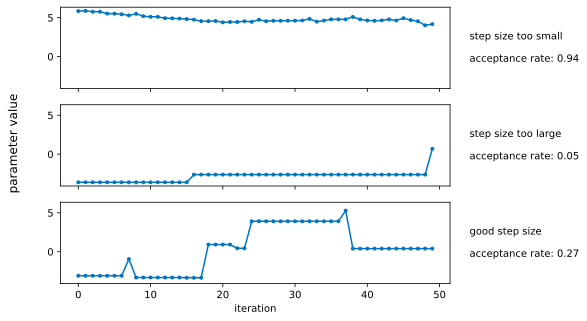

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(7, 5), sharey=True, sharex=True)
axs[0].plot(samples_small_cov[-50:], marker=".", label="step size too small")
axs[0].annotate(
    text=f"step size too small\n\nacceptance rate: {compute_acceptance_rate(samples_small_cov):.2f}",
    xy=(1.05, 0.5),
    xycoords="axes fraction",
    va="center"
)
axs[1].plot(samples_large_cov[-50:], marker=".", label="step size too large")
axs[1].annotate(
    text=f"step size too large\n\nacceptance rate: {compute_acceptance_rate(samples_large_cov):.2f}",
    xy=(1.05, 0.5),
    xycoords="axes fraction",
    va="center"
)
axs[2].plot(samples[-50:], marker=".", label="step size good")
axs[2].annotate(
    text=f"good step size\n\nacceptance rate: {compute_acceptance_rate(samples):.2f}",
    xy=(1.05, 0.5),
    xycoords="axes fraction",
    va="center"
)

plt.xlabel("iteration") 
fig.supylabel("parameter value")

glue("mcmc_acceptance_rate_plot", fig, display=False)

```{glue:figure} mcmc_acceptance_rate_plot
:width: 100%
:name: "fig-mcmc-acceptance-rate"

Trace plot showing the effect of different step sizes on the acceptance rate.
```

## MCMC beyond Metropolis-Hastings

### Gibbs sampling

In Gibbs sampling, not all parameters are updated at once within a Markov step.
Instead, parameters are updated sequentially (or in small groups) while keeping the remaining parameters fixed at their current values.
This means that, instead of sampling from the full joint target distribution, we only need to sample from the conditional distribution of the parameter being updated given the others.

In some cases, these conditional distributions are much simpler or even analytically tractable, which makes Gibbs sampling more efficient than updating all parameters simultaneously.

### Differential evolution adaptive Metropolis (DREAM)

The DREAM algorithm {cite:p}`vrugtAcceleratingMarkovChain2009` extends the Metropolis–Hastings framework by running several Markov chains in parallel — forming a “population” of chains.
These chains exchange information during sampling, borrowing ideas from evolutionary algorithms.
The proposal distribution is adapted automatically based on differences between the current states of the chains, which allows the sampler to more efficiently explore correlated or complex parameter spaces.

Because of its efficiency and robustness, DREAM has been widely adopted in engineering and environmental applications, particularly in hydrology and water resources modeling.

(sec-hmc)=
### Hamiltonian Monte Carlo

Hamiltonian Monte Carlo (HMC) overcomes the random-walk behavior of basic Metropolis-Hastings methods, which can lead to slow, local exploration and highly correlated samples.
It does so by using the gradient of the target distribution to guide the sampling process along efficient paths through parameter space.

The method draws an analogy to a physical system: the parameters are treated as positions and auxiliary momentum variables are introduced. The sampler then simulates the motion of this system, following smooth, energy-conserving trajectories through regions of high probability — much like a satellite moving in orbit under gravity.
The animation below shows how HMC can move rapidly across the target distribution, producing samples with much lower autocorrelation.

A detailed but accessible introduction to the more complex principles of HMC is given in {cite:t}`betancourtConceptualIntroductionHamiltonian2018`.
Modern, self-tuning variants of HMC such as the No-U-Turn Sampler (NUTS) make HMC widely usable and are implemented in probabilistic programming libraries like Stan and PyMC.
A limitation is that HMC requires gradients of the target distribution, which may be difficult to compute for complex numerical models.

````{div} full-width

<iframe src="https://chi-feng.github.io/mcmc-demo/app.html?algorithm=EfficientNUTS&target=banana"
        title="MCMC animation – HMC"
        width="1000"
        height="500"></iframe>

````